# Distance calculations and contact map plotting

## Content

This notebooks demonstrates how to calculate distances and contacts in PDB structures, and how to compare evolutionary couplings to them.

## Tutorial

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from evcouplings.couplings import read_raw_ec_file
from evcouplings.compare import (
    PDB, DistanceMap, SIFTS, intra_dists,
    multimer_dists, coupling_scores_compared
)

from evcouplings.visualize import plot_contact_map, plot_context

### Compute distances from 3D structures

First, we load index mapping information from the SIFTS database. If the two files in the constructor do not exist, they will be created automatically by fetching and processing the data from SIFTS (this may take a while).

In [3]:
s = SIFTS("../../databases/sifts/pdb_chain_uniprot_plus.csv", "../../databases/sifts/pdb_chain_uniprot_plus.fa")

There are three options to select structures for distance calculation:

#### By PDB ID

The hits can be further narrowed down by specifying the pdb_chain and uniprot_id parameters of s.by_pdb_id (this is especially necessary if the PDB contains multiple Uniprot entities so there is no ambiguity in which sequence the distances correspond to).

In [4]:
selected_structures = s.by_pdb_id("1ifw")
selected_structures.hits

,pdb_id,pdb_chain,mapping_index
0,1ifw,A,0


#### By Uniprot ID/AC

Finds all PDB structures for a given Uniprot ID/AC. reduce_chains=True will only keep one chain per PDB ID (set to False if interested in homomultimeric contacts).

In [5]:
selected_structures = s.by_uniprot_id("PABP_YEAST", reduce_chains=False)
selected_structures.hits

,pdb_id,pdb_chain,mapping_index
0,1ifw,A,0


Given that there are is very limited structure information for PABP_YEAST, we would like to compare against the structures that were solved for homologs.

#### By homology search

Finds structures by running a sequence alignment against the sequences of proteins in the PDB (these are the corresponding Uniprot sequences, not the SEQRES sequences). reduce_chains=True will only keep one chain per PDB ID (set to False if interested in homomultimeric contacts).

In [6]:
selected_structures = s.by_alignment(
    reduce_chains=True, sequence_id="PABP_YEAST", region=(115, 210),
    jackhmmer="../../software/hmmer-3.1b2-macosx-intel/binaries/jackhmmer",
)

selected_structures.hits

/Users/thomashopf/anaconda2/envs/python3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,pdb_id,alignment_id,pdb_chain,uniprot_ac,uniprot_id,alignment_start,alignment_end,bitscore,e_value,resseq_start,resseq_end,coord_start,coord_end,uniprot_start,uniprot_end,uniprot_id_,overlap,mapping_index,grouped_segments
0,1cvj,sp|P11940|PABP1_HUMAN/88-181,H,P11940,PABP1_HUMAN,88,181,120.6,5.1e-35,1,190,1,190,1,190,PABP1_HUMAN,93,110,False
3,2k8g,sp|P11940|PABP1_HUMAN/88-181,A,P11940,PABP1_HUMAN,88,181,120.6,5.1e-35,3,95,90,182,90,182,PABP1_HUMAN,91,115,False
6,4f02,sp|P11940|PABP1_HUMAN/88-181,A,P11940,PABP1_HUMAN,88,181,120.6,5.1e-35,6,195,1,190,1,190,PABP1_HUMAN,93,138,False
7,4f25,sp|P11940|PABP1_HUMAN/88-181,A,P11940,PABP1_HUMAN,88,181,120.6,5.1e-35,6,106,99,199,99,199,PABP1_HUMAN,82,140,False
8,4f26,sp|P11940|PABP1_HUMAN/88-181,A,P11940,PABP1_HUMAN,88,181,120.6,5.1e-35,6,106,99,199,99,199,PABP1_HUMAN,82,141,False
1,1x5t,sp|Q15427|SF3B4_HUMAN/100-175,A,Q15427,SF3B4_HUMAN,100,175,56.7,4.8e-15,8,90,8,90,102,184,SF3B4_HUMAN,73,153,False
4,2mpu,tr|J7FTI7|J7FTI7_HORVU/11-86,A,J7FTI7,J7FTI7_HORVU,11,86,50.7,3.6e-13,1,92,1,92,1,92,J7FTI7_HORVU,75,164,False
5,4c7q,tr|D6PZY5|D6PZY5_TOBAC/18-84,A,D6PZY5,D6PZY5_TOBAC,18,84,49.7,7.6e-13,2,86,1,85,1,85,D6PZY5_TOBAC,66,163,False
2,2d9p,sp|P11940|PABP1_HUMAN/293-375,A,P11940,PABP1_HUMAN,293,375,48.4,1.9e-12,8,97,286,375,286,375,PABP1_HUMAN,82,64,False


#### Compute distance maps

Based on the selected hits, we can compute distance maps for all structures. These are then aggregated into one distance map by minimizing across the distances for any residue pairs.

*Note there is also a function for comparing inter-chain distances, e.g. in hetero-complexes, inter_dists(), which this tutorial currently does not cover.*

In [7]:
distmap_intra = intra_dists(selected_structures)
distmap_multimer = multimer_dists(selected_structures)

/Users/thomashopf/anaconda2/envs/python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


Distance maps can be saved to disk and loaded again later:

In [8]:
distmap_intra.to_file("PABP_YEAST_distance_map")
distmap_intra = distmap_intra.from_file("PABP_YEAST_distance_map")

Accessing pair distances:

In [9]:
distmap_intra.dist(127, 172)

1.9027243625917019

#### Distance map computation without SIFTS

Beneath the high-level functions using SIFTS, there are functions that allow to directly access PDB data and compute distances. The results will however not be automatically mapped into Uniprot numbering spaces.

Obtain coordinates of a PABP_YEAST structure in human:

In [10]:
coords = PDB.from_id("1cvj").get_chain("A")

In [11]:
coords.residues.head()

,id,seqres_id,coord_id,one_letter_code,three_letter_code,chain_index,chain_id,sec_struct,sec_struct_3state
0,11,11,11,A,ALA,8,I,C,C
1,12,12,12,S,SER,8,I,E,E
2,13,13,13,L,LEU,8,I,E,E
3,14,14,14,Y,TYR,8,I,E,E
4,15,15,15,V,VAL,8,I,E,E


In [12]:
coords.coords.head()

,residue_index,atom_id,atom_name,x,y,z
0,0,1275,N,14.600,120.748,18.482
1,0,1276,CA,15.439,119.683,19.097
2,0,1277,C,16.921,119.971,18.954
3,0,1278,O,17.731,119.040,18.923
4,0,1279,CB,15.121,118.334,18.472


Compute distance map for intra-chain contacts:

In [13]:
distmap_pdb = DistanceMap.from_coords(coords)

DistanceMap.from_coords can receive a second PDB chain, which allows to compute inter-chain distances.

### Plot and compare evolutionary couplings to distance maps

#### Load evolutionary couplings

Here, we load ECs from an _ECs.txt file:

In [14]:
ecs = read_raw_ec_file("example/PABP_YEAST_ECs.txt")

We could also load a _CouplingsScores.csv file:

In [15]:
ecs = pd.read_csv("example/PABP_YEAST_CouplingScores.csv")

In [16]:
ecs.head()

,i,A_i,j,A_j,fn,cn
0,129,F,131,K,0,2.978298
1,151,D,174,E,0,2.492234
2,138,D,141,A,0,2.474682
3,175,E,178,A,0,2.462878
4,141,A,192,N,0,2.452096


Select ECs for plotting (here only top 100 pairs distant in sequence):

#### Plot contact map

In [17]:
# show these many long-range ECs
longrange_ecs = ecs.query("abs(i - j) > 5")
num_ecs = 100
show_ecs = longrange_ecs.iloc[:num_ecs]

/Users/thomashopf/Dropbox/EVcouplings2/EVcouplings/evcouplings/compare/distances.py:384: RuntimeWarning: invalid value encountered in less_equal
  cond = np.where(self.dist_matrix <= max_dist)


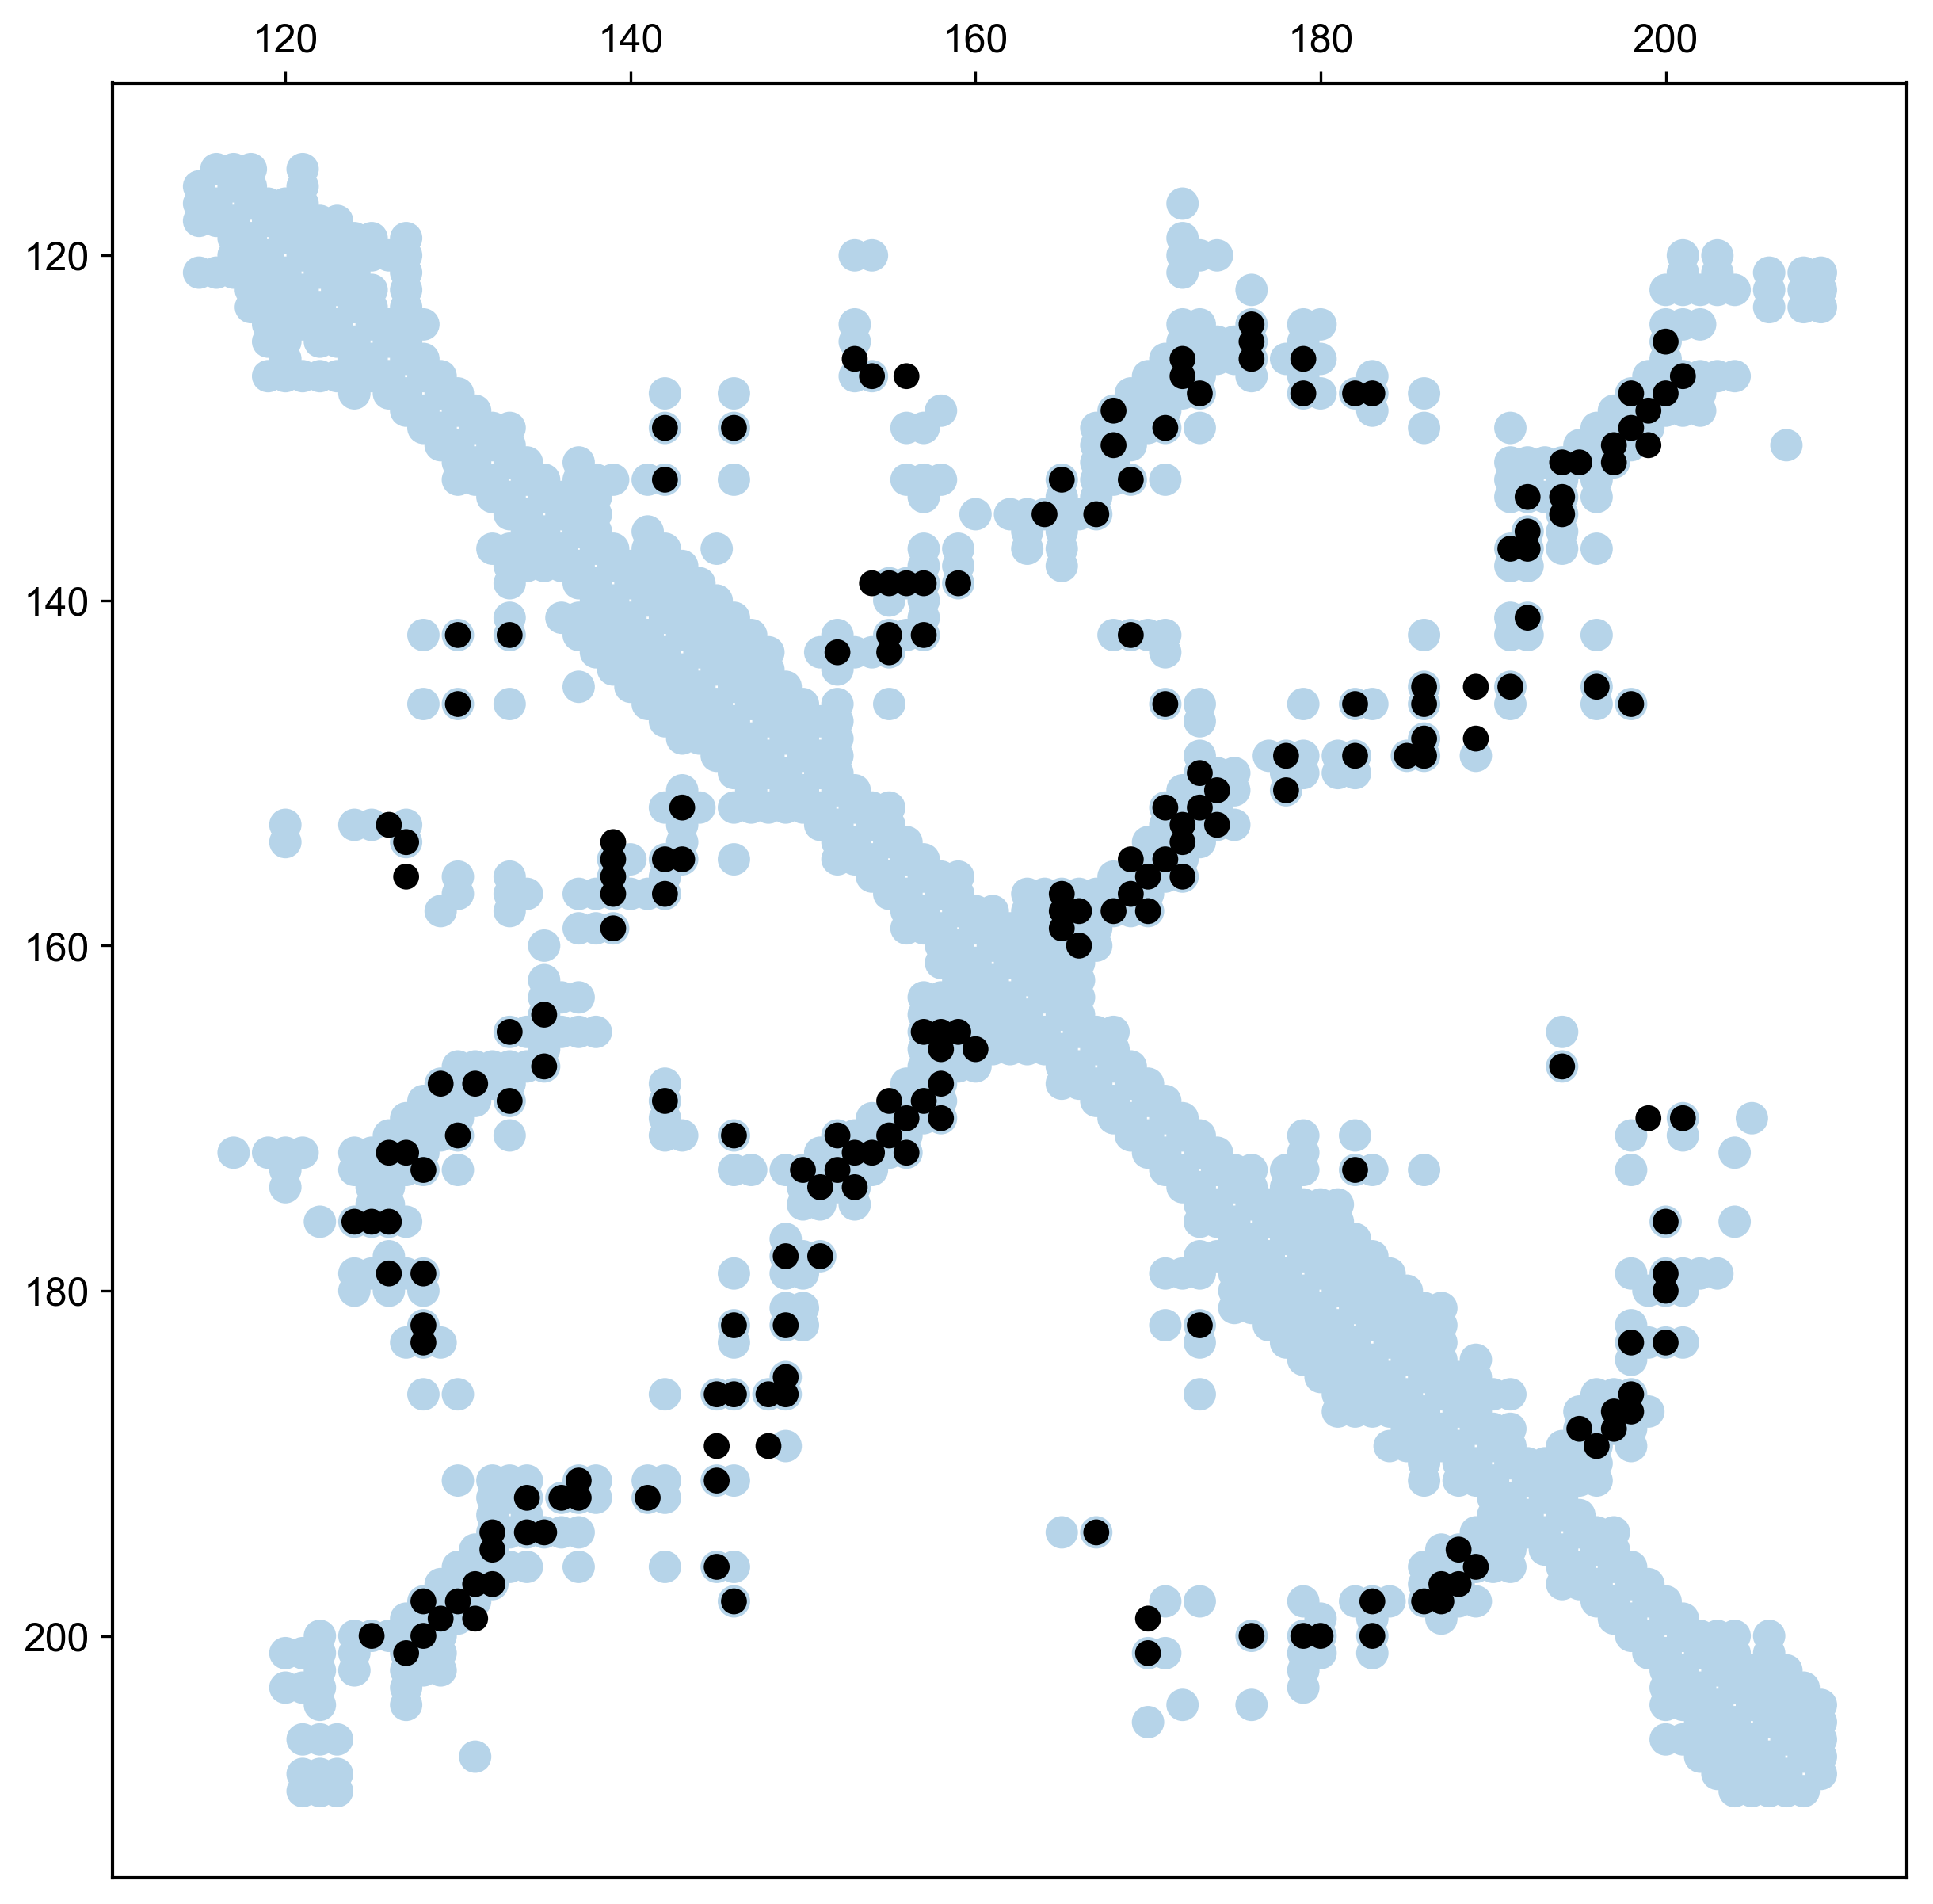

In [18]:
with plot_context("Arial"):
    plt.figure(figsize=(10, 10))
    
    plot_contact_map(
        show_ecs, distmap_intra, distmap_multimer
    )

#### Create EC table that contains pair distances and EC precision for all pairs

In [19]:
cc = coupling_scores_compared(
    ecs, distmap_intra, distmap_multimer,
    dist_cutoff=5,
    output_file="CouplingScoresCompared.csv"
)

cc.head()

,i,A_i,j,A_j,fn,cn,dist,precision
1,151,D,174,E,0,2.492234,1.592173,1.0
4,141,A,192,N,0,2.452096,1.651097,1.0
5,153,L,174,E,0,2.408565,1.785927,1.0
6,149,F,185,A,0,2.230486,1.776481,1.0
7,149,F,186,L,0,2.066847,1.977190,1.0
